In [1]:
#@title Import packages for plotting and creating graphics
import time
import itertools
import numpy as np
from typing import Callable, NamedTuple, Optional, Union, List

import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

In [2]:
#@title Import MuJoCo, MJX, and Brax
from datetime import datetime
from etils import epath
import functools
from IPython.display import HTML
from typing import Any, Dict, Sequence, Tuple, Union
import os
# from ml_collections import config_dict


import jax
from jax import numpy as jp
import numpy as np
# from flax.training import orbax_utils
# from flax import struct
from matplotlib import pyplot as plt
import mediapy as media
# from orbax import checkpoint as ocp

import mujoco
from mujoco import mjx

from brax import base
from brax import envs
from brax import math
from brax.base import Base, Motion, Transform
from brax.envs.base import Env, PipelineEnv, State
from brax.mjx.base import State as MjxState
from brax.training.agents.ppo import train as ppo
from brax.training.agents.ppo import networks as ppo_networks
from brax.io import html, mjcf, model
from brax.base import System

from copy import deepcopy as dc

# TwoArm URM Env


In [12]:
# #@title TwoArm Env


# class TwoArm(PipelineEnv):

#   def __init__(
#       self,
#       forward_reward_weight=1.25,
#       ctrl_cost_weight=0.1,
#       healthy_reward=5.0,
#       terminate_when_unhealthy=True,
#       healthy_z_range=(1.0, 2.0),
#       reset_noise_scale=1e-2,
#       exclude_current_positions_from_observation=True,
#       **kwargs,
#   ):
#     d = 0.15
#     l1, l2 = 0.14, 0.14
#     bs = 0.15
#     q_limit = 2.5
#     savevideo =False

#     xml = '''
#     <mujoco>
#         <compiler angle="radian" />
#         <option  timestep="0.001" gravity="0 0 0"/>
#         <default>
#           <geom solref="0.002 1" contype="1" conaffinity="1" friction="0.3 0.005 0.0001" />
#           <joint  armature="0.01" range="-{5} {5}"/>
#         </default>
#         <visual>
#           <map stiffness="10000"/>
#           <global offheight="1280" offwidth="1280"/>
#         </visual>
#         <asset>
#           <texture type="skybox" builtin="gradient" rgb1=".3 .5 .7" rgb2="0 0 0" width="32" height="512"/>
#           <texture name="body" type="cube" builtin="flat" mark="cross" width="128" height="128" rgb1="0.8 0.6 0.4" rgb2="0.8 0.6 0.4" markrgb="1 1 1"/>
#           <material name="body" texture="body" texuniform="true" rgba="0.8 0.6 .4 1"/>
#           <texture name="grid" type="2d" builtin="checker" width="512" height="512" rgb1=".1 .2 .3" rgb2=".2 .3 .4"/>
#           <material name="grid" texture="grid" texrepeat="4 4" texuniform="false" reflectance=".0"/>
#         </asset>

#         <worldbody>
#             <geom name="floor" type="plane" size=".4 .4 0.01" material="grid" pos="0 0.2 -0.025"/>
#             <camera name="top" pos="0 0 1.0" resolution="1280 1280"/>
#             <body name="robot">
#             <geom name="base" type="capsule" size="0.01" fromto="-{3} -0.02 0 {3} -0.02 0" />
#             <body name="R1" pos="{0} 0 0.0">
#                 <geom type="capsule" size="0.01" fromto="0 0 0 0 {1} 0" rgba="0 0 0 1"/>
#                 <joint name="R1j" type="hinge" pos="0 0 0" axis="0 0 1" />
#                 <body name="R2" pos="0 {1} 0">
#                     <geom type="capsule" size="0.01" fromto="0 0 0 0 {2} 0" />
#                     <joint name="R2j" type="hinge" pos="0 0 0" axis="0 0 1" />
#                 </body>
#             </body>
#             <body name="L1" pos="-{0} 0 0">
#                 <geom type="capsule" size="0.01" fromto="0 0 0 0 {1} 0" rgba="0 0 0 1"/>
#                 <joint name="L1j" type="hinge" pos="0 0 0" axis="0 0 1" />
#                 <body name="L2" pos="0 {1} 0">
#                     <geom type="capsule" size="0.01" fromto="0 0 0 0 {2} 0"/>
#                     <joint name="L2j" type="hinge" pos="0 0 0" axis="0 0 1" />
#                 </body>
#             </body>
#             </body>
#             <body name="obj" pos="0 {4} 0.0">
#               <joint type="slide" axis="1 0 0"/>
#               <joint type="slide" axis="0 1 0"/>
#               <joint type="hinge" axis="0 0 1"/>
#               <!-- <geom type="capsule" size="{4} 0.025" pos="0 0 0"/> -->
#               <geom type="box" size="{4} {4} 0.025" pos="0 0 0"/> 
#               <!-- <geom type="box" size="{4} 0.01 0.025" pos="0 0 0"/> -->
#               <!-- <geom type="box" size="0.01 {4} 0.025" pos="0 0 0"/> -->
#               <!-- <geom type="box" size="0.02 0.02 0.025" pos="0 0 0"/> -->
#             </body>

#         </worldbody>

#         <actuator>
#           <general joint="R1j"/>
#           <general joint="R2j"/>
#           <general joint="L1j"/>
#           <general joint="L2j"/>
#           <damper joint="R1j" ctrlrange="0 100000" kv="1"/>
#           <damper joint="R2j" ctrlrange="0 100000" kv="1"/>
#           <damper joint="L1j" ctrlrange="0 100000" kv="1"/>
#           <damper joint="L2j" ctrlrange="0 100000" kv="1"/>
#         </actuator>

#     </mujoco>
#     '''.format(d, l1, l2, d - 0.02, bs/2, q_limit)
#     mj_model = mujoco.MjModel.from_xml_string(xml)
#     # mj_model.opt.solver = mujoco.mjtSolver.mjSOL_CG
#     # mj_model.opt.iterations = 6
#     # mj_model.opt.ls_iterations = 6

#     sys = mjcf.load_model(mj_model)

#     self.steps_per_control_step = 50
#     kwargs['n_frames'] = kwargs.get(
#         'n_frames', 1)
#     kwargs['backend'] = 'mjx'

#     super().__init__(sys, **kwargs)

#     self.e_list = jp.zeros((16, 4))
#     ct = 0
#     for i in range(2):
#       for j in range(2):
#         for k in range(2):
#           for l in range(2):
#             self.e_list = self.e_list.at[ct].set( jp.array([ (-1.0)**(i), (-1.0)**(j), (-1.0)**(k), (-1.0)**(l)  ]))
#             ct +=1
#     self.q_limit = q_limit

#     self._forward_reward_weight = forward_reward_weight
#     self._ctrl_cost_weight = ctrl_cost_weight
#     self._healthy_reward = healthy_reward
#     self._terminate_when_unhealthy = terminate_when_unhealthy
#     self._healthy_z_range = healthy_z_range
#     self._reset_noise_scale = reset_noise_scale
#     self._exclude_current_positions_from_observation = (
#         exclude_current_positions_from_observation
#     )
  
#   def transmission(self, d, w, e, f):
#     v = d.qvel[0:4]
#     ctrl = jp.zeros(self.sys.nu)
#     # ctrl.at[:4] = e * f
#     # ctrl.at[4:8] = jp.abs(v) * w
#     # return ctrl
#     return jp.concatenate([e*f, jp.abs(v) * w])
  
#   # def controller(self, d, e_idx, q_target):
#   def controller(self, d, action):
#     idx = jp.argmax(action)
#     e = self.e_list[idx].squeeze()

#     q = d.qpos[0:4]
#     v = d.qvel[0:4]
#     kp = 10.0

#     f = kp* (jp.dot(e,(e * self.q_limit  - q - 2 * np.sqrt([0.01/kp]) * v)))
#     w = 0.1
#     return w, e, f

#   def reset(self, rng: jp.ndarray) -> State:
#     """Resets the environment to an initial state."""
#     rng, rng1, rng2 = jax.random.split(rng, 3)

#     low, hi = -self._reset_noise_scale, self._reset_noise_scale
#     qpos = self.sys.qpos0 + 0.0 * jax.random.uniform(
#         rng1, (self.sys.nq,), minval=low, maxval=hi
#     )
#     qvel = 0.0 * jax.random.uniform(
#         rng2, (self.sys.nv,), minval=low, maxval=hi
#     )

#     data = self.pipeline_init(qpos, qvel)

#     obs = self._get_obs(data, jp.zeros(self.sys.nu))
#     reward, done, zero = jp.zeros(3)
#     metrics = {
#         'reward': zero,
#         'y_reward': zero, 
#         'x_reward': zero,
#         'theta_reward': zero
#     }
#     return State(data, obs, reward, done, metrics)

#   @property
#   def action_size(self) -> int:
#     return 16

#   @property
#   def dt(self) -> float:
#     return self.sys.opt.timestep * self.steps_per_control_step

#   def step(self, state: State, action: jp.ndarray) -> State:
#     """Runs one timestep of the environment's dynamics."""
#     data = state.pipeline_state

#     def f(d, _):
#       w, e, f = self.controller(d, action)
#       ctrl = self.transmission(d, w, e, f)
#       return (self._pipeline.step(self.sys, d, ctrl, self._debug), None)
#     # for _ in range(self.steps_per_control_step ):
#     #   w, e, f = self.controller(data, action)
#     #   ctrl = self.transmission(data, w, e, f)
#     #   data = self.pipeline_step(data, ctrl)
#     data = jax.lax.scan(f, data, (), self.steps_per_control_step)[0]

    
#     obs = self._get_obs(data, action)
#     x_reward = -data.qpos[4] * data.qpos[4]
#     y_reward = -data.qpos[5] * data.qpos[5]
#     theta_reward = -(data.qpos[6] - 1.57) * (data.qpos[6] - 1.57)
#     reward =  theta_reward + 10.0 * y_reward# forward_reward + healthy_reward - ctrl_cost
#     done = 0.0
#     state.metrics.update(
#         reward = reward,
#         y_reward = y_reward,
#         x_reward = x_reward
#     )

#     return state.replace(
#         pipeline_state=data, obs=obs, reward=reward, done=done
#     )

#   def _get_obs(
#       self, data: mjx.Data, action: jp.ndarray
#   ) -> jp.ndarray:
#     """Observes humanoid body position, velocities, and angles."""
#     # external_contact_forces are excluded
#     return jp.concatenate([
#         data.qpos,
#         data.qvel
#     ])


# envs.register_environment('twoarm', TwoArm)

## Visualize a Rollout

Let's instantiate the environment and visualize a short rollout.

NOTE: Since episodes terminates early if the torso is below the healthy z-range, the only relevant contacts for this task are between the feet and the plane. We turn off other contacts.

In [ ]:
# instantiate the environment
env_name = 'urm2arm_prop'
env = envs.get_environment(env_name)




In [5]:
# define the jit reset/step functions
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)
# initialize the state
state = jit_reset(jax.random.PRNGKey(0))
rollout = [state.pipeline_state]

In [ ]:
# grab a trajectory
key = jax.random.key(110)
for i in range(20):
  key, _ = jax.random.split(key,2)
  print(env.action_size)
  idx = jax.random.randint(key, 1, 0, env.action_size)
  print(idx)
  ctrl = jp.zeros(16)
  ctrl = ctrl.at[idx].set(1.0)
  print(idx, ctrl)
  state = jit_step(state, ctrl)
  # print(state.ctrl)
  rollout.append(state.pipeline_state)
print("done")
print(env.e_list[idx])

In [ ]:
media.show_video(env.render(rollout, camera='top'), fps=1.0 / env.dt)

In [ ]:
print(jax.devices('gpu')[0])

## Train Two Arm URM Policy

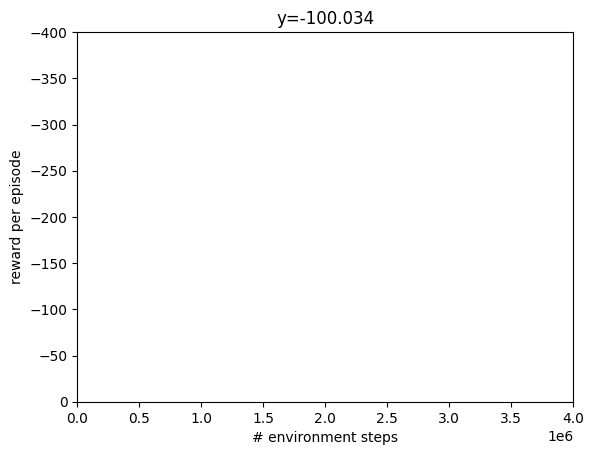

: 

In [3]:
# instantiate the environment
env_name = 'urm2arm_prop'
env = envs.get_environment(env_name)

def policy_params_fn(current_step, make_policy, params):
  model_path = '/home/tlee_theaiinstitute_com/mjx_brax_policy/test_new_{}'.format(current_step)
  model.save_params(model_path, params)


num_evals= 50
train_fn = functools.partial(
    ppo.train, num_timesteps=40*num_evals*1000, 
    num_evals=num_evals, reward_scaling=0.1,
    episode_length=40, normalize_observations=False, action_repeat=1,
    unroll_length=40, num_minibatches=10, num_updates_per_batch=2,
    discounting=0.97, learning_rate=3e-4, entropy_cost=1e-3, num_envs=1000, clipping_epsilon=0.3,
    batch_size=100, seed=0, discrete_action = False, spectral_norm_actor = False, policy_params_fn=policy_params_fn)


x_data = []
y_data = []
ydataerr = []
times = [datetime.now()]

max_y, min_y = -400, 0
def progress(num_steps, metrics):
  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics['eval/episode_reward'])
  ydataerr.append(metrics['eval/episode_reward_std'])
  # print(datetime.now(), num_steps, metrics['eval/episode_reward'])

  plt.xlim([0, train_fn.keywords['num_timesteps'] * 2.0])
  plt.ylim([min_y, max_y])

  plt.xlabel('# environment steps')
  plt.ylabel('reward per episode')
  plt.title(f'y={y_data[-1]:.3f}')

  plt.errorbar(x_data, y_data, yerr=ydataerr)
  plt.show()

make_inference_fn, params, _= train_fn(environment=env, progress_fn=progress)

print(f'time to jit: {times[1] - times[0]}' )
print(f'time to train: {times[-1] - times[1]}')

<!-- ## Save and Load Policy -->

We can save and load the policy using the brax model API.

In [14]:
#@title Save Modelz
model_path = '/home/tlee_theaiinstitute_com/mjx_brax_policy/test'
model.save_params(model_path, params)

In [15]:
#@title Load Model and Define Inference Function
params = model.load_params(model_path)

inference_fn = make_inference_fn(params)
jit_inference_fn = jax.jit(inference_fn)

## Visualize Policy

Finally we can visualize the policy.

In [16]:
eval_env = envs.get_environment(env_name)

jit_reset = jax.jit(eval_env.reset)
jit_step = jax.jit(eval_env.step)

In [17]:
# initialize the state
rng = jax.random.PRNGKey(10)
state = jit_reset(rng)
rollout = [state.pipeline_state]

# grab a trajectory
n_steps = 40
render_every = 2

for i in range(n_steps):
  act_rng, rng = jax.random.split(rng)
  ctrl, _ = jit_inference_fn(state.obs, act_rng)
  state = jit_step(state, ctrl)
  rollout.append(state.pipeline_state)
  # print(state.pipeline_state.qpos, state.reward)
  print(ctrl, state.reward)
  # print(state.done)
  # if state.done:
  #   break
print("done")
# media.write_video('/home/tlee_theaiinstitute_com/mjx_brax_policy/rotate_90deg.mp4', env.render(rollout[::render_every], camera='top'), fps=1.0 / env.dt / render_every)
media.show_video(env.render(rollout[::render_every], camera='top'), fps=1.0 / env.dt / render_every)

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] -2.2880535
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] -1.9910791
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] -1.881873
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] -1.8588538
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] -1.8458953
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] -1.7253674
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] -1.8250092
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] -1.5081272
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] -1.3854427
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] -1.328263
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] -1.015735
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] -1.0778407
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] -0.9599339
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] -0.675817
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] -0.6461376
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] -0.5777777
[0. 0. 0. 1. 0. 0. 0. 0. 0. 

In [ ]:
print(len(rollout))

# MJX Policy in MuJoCo

We can also perform the physics step using the original MuJoCo python bindings to show that the policy trained in MJX works in MuJoCo.

In [ ]:
mj_model = eval_env.sys.mj_model
mj_data = mujoco.MjData(mj_model)

renderer = mujoco.Renderer(mj_model)
ctrl = jp.zeros(mj_model.nu)
images = []
for i in range(n_steps):
  act_rng, rng = jax.random.split(rng)

  obs = eval_env._get_obs(mjx.put_data(mj_model, mj_data), ctrl)
  ctrl, _ = jit_inference_fn(obs, act_rng)
  print(ctrl)
  
  mj_data.ctrl = ctrl
  for _ in range(eval_env._n_frames):
    mujoco.mj_step(mj_model, mj_data)  # Physics step using MuJoCo mj_step.
  # print(mj_data.qpos)
  if i % render_every == 0:
    renderer.update_scene(mj_data, camera='side')
    images.append(renderer.render())
# plt.show(images[100])
media.show_video(images) #, fps=1.0 / eval_env.dt / render_every)
print("done")
# media.write_video('/home/tlee_theaiinstitute_com/mjx_brax_policy/test.mp4', images, fps=1.0 / env.dt / render_every)

In [ ]:
mj_model = eval_env.sys.mj_model
mj_data = mujoco.MjData(mj_model)
mujoco.mj_step(mj_model, mj_data)
renderer.update_scene(mj_data, camera='side')
im = renderer.render()
plt.imshow(im)

# Training a Policy with Domain Randomization

We might also want to include randomization over certain `mjModel` parameters while training a policy. In MJX, we can easily create a batch of environments with randomized values populated in `mjx.Model`. Below, we show a function that randomizes friction and actuator gain/bias.

In [ ]:
def domain_randomize(sys, rng):
  """Randomizes the mjx.Model."""
  @jax.vmap
  def rand(rng):
    _, key = jax.random.split(rng, 2)
    # friction
    friction = jax.random.uniform(key, (1,), minval=0.6, maxval=1.4)
    friction = sys.geom_friction.at[:, 0].set(friction)
    # actuator
    _, key = jax.random.split(key, 2)
    gain_range = (-5, 5)
    param = jax.random.uniform(
        key, (1,), minval=gain_range[0], maxval=gain_range[1]
    ) + sys.actuator_gainprm[:, 0]
    gain = sys.actuator_gainprm.at[:, 0].set(param)
    bias = sys.actuator_biasprm.at[:, 1].set(-param)
    return friction, gain, bias

  friction, gain, bias = rand(rng)

  in_axes = jax.tree_util.tree_map(lambda x: None, sys)
  in_axes = in_axes.tree_replace({
      'geom_friction': 0,
      'actuator_gainprm': 0,
      'actuator_biasprm': 0,
  })

  sys = sys.tree_replace({
      'geom_friction': friction,
      'actuator_gainprm': gain,
      'actuator_biasprm': bias,
  })

  return sys, in_axes

If we wanted 10 environments with randomized friction and actuator params, we can call `domain_randomize`, which returns a batched `mjx.Model` along with a dictionary specifying the axes that are batched.

In [ ]:
rng = jax.random.PRNGKey(0)
rng = jax.random.split(rng, 10)
batched_sys, _ = domain_randomize(env.sys, rng)

print('Single env friction shape: ', env.sys.geom_friction.shape)
print('Batched env friction shape: ', batched_sys.geom_friction.shape)

print('Friction on geom 0: ', env.sys.geom_friction[0, 0])
print('Random frictions on geom 0: ', batched_sys.geom_friction[:, 0, 0])